# PCA: What drives the ASI features

PCA reduces several related signals into a few summary axes. We use it to explain which stress signals move together. This is an interpretation tool, not a prediction model.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


## Setup and inputs

Load the analysis libraries and prepare to read the scaled feature file.

In [2]:
data_path = Path('data/processed/features_scaled.csv')
figures_dir = Path('report/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
loadings_path = Path('data/processed/pca_loadings.csv')

feature_cols = [
    'rent_to_income_scaled',
    'rent_growth_yoy_scaled',
    'vacancy_stress_scaled',
]


### Paths and feature list

Define the input file and the exact columns used for PCA. These are the same three stress signals used in the ASI.

In [3]:
df = pd.read_csv(data_path)
features = df[feature_cols]
complete = features.dropna()

print(f'Total rows: {len(df):,}')
print(f'Rows with complete features: {len(complete):,}')
complete.head()


Total rows: 41
Rows with complete features: 18


,rent_to_income_scaled,rent_growth_yoy_scaled,vacancy_stress_scaled
7,-0.784555,-0.513761,-0.7
11,1.259004,0.660550,0.4
12,0.143952,-1.211009,-0.5
16,0.625522,-0.587156,-1.0
18,1.580833,-0.293578,-0.9


### Inspect data completeness

PCA needs complete rows. We count how many metros have all three signals so you know how much data feeds the PCA.

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(complete)

pca = PCA(n_components=min(len(feature_cols), X.shape[1]))
X_pca = pca.fit_transform(X)

explained = pca.explained_variance_ratio_
explained


array([0.59869491, 0.25500048, 0.14630461])

### Standardize again for PCA stability

Even after robust scaling, we standardize to mean 0 and variance 1 so no feature dominates the PCA because of scale.

PosixPath('report/figures/pca_explained_variance.png')

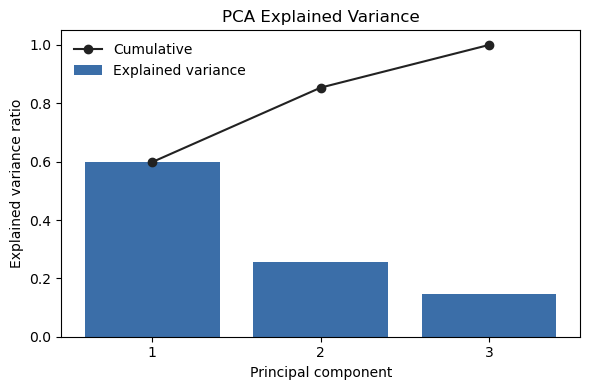

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
components = np.arange(1, len(explained) + 1)
ax.bar(components, explained, color='#3b6ea8', label='Explained variance')
ax.plot(components, explained.cumsum(), color='#222222', marker='o', label='Cumulative')
ax.set_xlabel('Principal component')
ax.set_ylabel('Explained variance ratio')
ax.set_title('PCA Explained Variance')
ax.set_xticks(components)
ax.legend(frameon=False)
fig.tight_layout()

plot_path = figures_dir / 'pca_explained_variance.png'
fig.savefig(plot_path, dpi=200)
plot_path


### Explained-variance diagnostics

Plot how much variance each component explains so we can see how many components matter.

In [6]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f'PC{i}' for i in components],
)

loadings['abs_PC1'] = loadings['PC1'].abs()
loadings['abs_PC2'] = loadings['PC2'].abs()
if 'PC3' in loadings.columns:
    loadings['abs_PC3'] = loadings['PC3'].abs()

loadings_sorted = loadings.sort_values('abs_PC1', ascending=False)
loadings_sorted.to_csv(loadings_path)
loadings_sorted


,PC1,PC2,PC3,abs_PC1,abs_PC2,abs_PC3
vacancy_stress_scaled,0.628850,0.273485,0.727842,0.628850,0.273485,0.727842
rent_growth_yoy_scaled,0.611771,0.403712,-0.680260,0.611771,0.403712,0.680260
rent_to_income_scaled,-0.479879,0.873054,0.086564,0.479879,0.873054,0.086564


### Component loadings for interpretability

Loadings show how strongly each original feature contributes to each component. This helps us explain the PCA axes in plain language.

In [7]:
def summarize_pc(pc_name: str, top_n: int = 2) -> str:
    series = loadings[pc_name].sort_values(key=lambda s: s.abs(), ascending=False)
    top = series.head(top_n)
    parts = [f"{idx} ({val:+.2f})" for idx, val in top.items()]
    return f"{pc_name}: " + ", ".join(parts)

for pc_name in loadings.columns[:3]:
    print(summarize_pc(pc_name))


PC1: vacancy_stress_scaled (+0.63), rent_growth_yoy_scaled (+0.61)
PC2: rent_to_income_scaled (+0.87), rent_growth_yoy_scaled (+0.40)
PC3: vacancy_stress_scaled (+0.73), rent_growth_yoy_scaled (-0.68)


### Plain-language interpretation

- PC1: a combined signal of tight vacancy and fast rent growth.
- PC2: metros where rent already takes a large share of income.
- PC3: cases where vacancy and rent growth do not move together.

These are patterns in the data, not cause-and-effect claims.